In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt
# import tensorwatch as tw
import time

import torch
import copy
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

from utils.dataset import *
import torch.utils.data as data

from utils.train import *
from utils.test  import *
from utils.model_select import model_select

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [2]:
# Training settings
####### test作训练集 #######
# epochs = 80
# lr = 3e-6
# gamma = 0.7
# step_size = 5
###### train作训练集 #######
epochs = 5
lr = 2e-6
gamma = 0.8
step_size = 2

seed = 42
device = 'cpu'

file_Path = '/home/a611/Projects/Datasets/CSE_v1/images/'
train_name = ['/home/a611/Projects/Datasets/CSE_v1/labels/train_aver_75.csv']
test_name = ['/home/a611/Projects/Datasets/CSE_v1/labels/train_aver_25.csv']
num_classes = 11
num_input = 3
batch_size = 16
num_workers = 8
########################
# os.chdir('examples')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## Load Data

In [4]:
train_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

## Load Datasets

In [5]:
label_map = get_map(test_name)
label_key = list(label_map.keys())
train_set = MyDataset(file_Path, train_name, label_map,
                            train_transforms)
train_loader = data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

valid_set = MyDataset(file_Path, test_name, label_map,
                            val_transforms)
valid_loader = data.DataLoader(
    dataset=valid_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [6]:
print(len(train_loader))
print(len(valid_loader))

557
186


## Effecient Attention

### Training

In [7]:
model = model_select('ResNet18', num_input, 90).to(device)
# print(model)
model = torch.nn.DataParallel(model)
# model_state_disk = torch.load('/home/a611/Projects/msk/fewshot_main/Model/pretrain/ResNet18/test_acc_0.743311_epoch_33', map_location = device)
# model.load_state_dict(model_state_disk)
model = model.module
model.linear = torch.nn.Linear(512, num_classes)

model = model.to(device)
# print(model)

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
# model_ = None
# highest_test_acc = 0
# for i in range(epochs):
#     # print('EPOCH:', i + 1)
#     train_iter = iter(train_loader)
#     test_iter = iter(valid_loader)
#     ########################################
#     train_loss, train_acc = train(model, device, train_iter, optimizer, train_set, batch_size)
#     test_loss, test_acc = test(model, device, test_iter, valid_set, batch_size)
#     scheduler.step()
#     print( 'EPOCH: %03d, train_loss: %3f, train_acc: %3f, test_loss: %3f, test_acc: %3f'
#           % (i + 1, train_loss, train_acc, test_loss, test_acc))
#     if test_acc > highest_test_acc:
#         highest_test_acc = test_acc
#         model_ = copy.deepcopy(model)
#         print('Highest test accuracy: %3f' % highest_test_acc)
#         torch.save(model_, '../models/CSE_train.model')
#     print( 'EPOCH: %03d, train_loss: %3f, train_acc: %3f' % (i + 1, train_loss, train_acc))

In [9]:
# model = torch.load('/home/a611/Projects/gyc/Local_Features/models/CSE_train.model', map_location = device)
# # print(model.layer4)

In [31]:
def draw(x, output, input_type):
    output_max = output.argmax(dim=1)
    output_numpy = output.cpu().detach().numpy()
    print(output_numpy.shape)
    fig, ax = plt.subplots(figsize=(12, 8))
    y = output_numpy[0]
    ax.bar(x = x, height = y)
    ax.set_title('Item: %s.' % x[int(output_max)], fontsize=15);
    xticks = ax.get_xticks()
    for i in range(len(y)):
        xy = (xticks[i], y[i])
        s = '%03f' % y[i]
        ax.annotate(
            text=s,  # 要添加的文本
            xy=xy,  # 将文本添加到哪个位置
            fontsize=8,  # 标签大小
            color="red",  # 标签颜色
            ha="center",  # 水平对齐
            va="baseline"  # 垂直对齐
        )
        plt.savefig("../results/%s_%s.jpg" % (input_type, x[int(output_max)]))
    return output_max

def result(x, output, input_type):
    output_max = output.argmax(dim=1)
    print('Input: %s; Item: %s.' % (input_type, x[int(output_max)]))
    return output_max

(1, 11)
[-0.00398824 -0.01471778  0.01778925  0.05218293  0.03572224  0.01968374
 -0.01347371 -0.0342707   0.03887536  0.02515016 -0.02218518]


FileNotFoundError: [Errno 2] No such file or directory: '../results/_container.jpg'

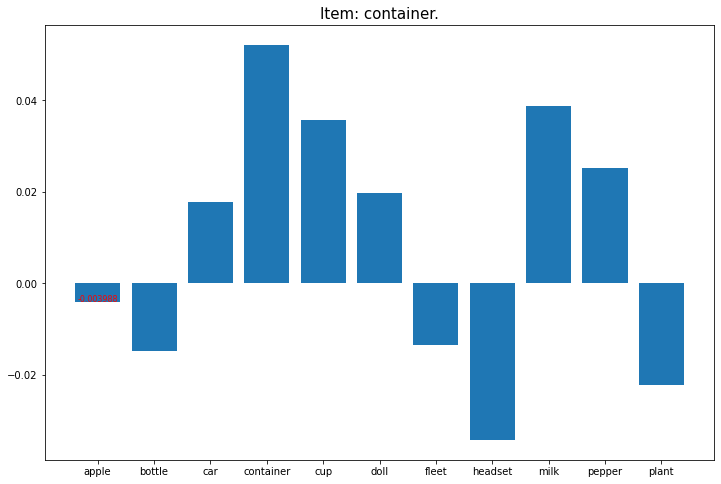

In [32]:
import re
device = 'cpu'
model.eval()
model.to(device)
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
#########################################
# # for input_file_name in os.listdir('inputs'):
# input_file_name = 'doll_86.jpg'
# image_name = os.path.join('inputs',input_file_name)
# image = Image.open(image_name)
# img = image.resize((224, 224))
# input = test_transforms(image).unsqueeze(0)
# input = input.to(device)
# output = model(input)
# # output_max = draw(label_key, output)
# output_max = result(label_key, output, 'origin')
# output_max = draw(label_key, output, 'origin')

root_dir = '../sample_pairs'


image_name = 'doll_1_pitch0_chess_position0_angle45.jpeg'
image = Image.open(image_name)
img = image.resize((224, 224))
input = test_transforms(image).unsqueeze(0)
input = input.to(device)
output = model(input)
output_max = draw(label_key, output,  '')
# output_max = result(label_key, output, '' )
#         output_max = draw(label_key, output, '%s, %s.' %(catagory, item))
# real_index = label_key.index(re.split('[_.]', item)[0])
#         targets = [ClassifierOutputTarget(real_index)]
targets = [ClassifierOutputTarget(int(output_max))]
grayscale_cam = cam(input_tensor=input, targets = targets)
grayscale_cam = grayscale_cam[0, :]
image = np.array(image, dtype=np.float32) / 255
grayscale_cam = cv2.resize(grayscale_cam, (image.shape[1], image.shape[0]))
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)

im = Image.fromarray(visualization)

im.save("output_doll.jpg")
# im.save('../results/%s_%s_%s.jpg' % (catagory, item.split('.')[0], label_key[int(output_max)]))
        

In [12]:
# import re
# device = 'cpu'
# model.eval()
# model.to(device)
# target_layers = [model.layer4[-1]]
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
# #########################################
# # # for input_file_name in os.listdir('inputs'):
# # input_file_name = 'doll_86.jpg'
# # image_name = os.path.join('inputs',input_file_name)
# # image = Image.open(image_name)
# # img = image.resize((224, 224))
# # input = test_transforms(image).unsqueeze(0)
# # input = input.to(device)
# # output = model(input)
# # # output_max = draw(label_key, output)
# # output_max = result(label_key, output, 'origin')
# # output_max = draw(label_key, output, 'origin')

# root_dir = '../sample_pairs'

# catagories = os.listdir(root_dir)
# catagories.sort()
# for catagory in catagories:
#     acc = 0
#     total = 0
#     print('###################### %s ######################' % catagory)
#     items = os.listdir(os.path.join(root_dir, catagory))
#     items.sort()
#     for item in items:
#         image_name = os.path.join(root_dir, catagory, item)
#         image = Image.open(image_name)
#         img = image.resize((224, 224))
#         input = test_transforms(image).unsqueeze(0)
#         input = input.to(device)
#         output = model(input)
#         # output_max = draw(label_key, output)
#         output_max = result(label_key, output, '%s, %s.' %(catagory, item))
# #         output_max = draw(label_key, output, '%s, %s.' %(catagory, item))
#         real_index = label_key.index(re.split('[_.]', item)[0])
# #         targets = [ClassifierOutputTarget(real_index)]
#         targets = [ClassifierOutputTarget(int(output_max))]
#         grayscale_cam = cam(input_tensor=input, targets = targets)
#         grayscale_cam = grayscale_cam[0, :]
#         image = np.array(image, dtype=np.float32) / 255
#         grayscale_cam = cv2.resize(grayscale_cam, (image.shape[1], image.shape[0]))
#         visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
        
#         im = Image.fromarray(visualization)
        
#         im.save("../output.jpg")
#         im.save('../results/%s_%s_%s.jpg' % (catagory, item.split('.')[0], label_key[int(output_max)]))

#         if re.split('[_.]', item)[0] == label_key[int(output_max)]:
#             acc += 1
#         total += 1
#         time.sleep(1)
#     if total:
#         print('---------------------- Acc: {}%. ----------------------'.format(format(acc/total * 100, '.2f')))
        
        